#### Exploritory analyis of the dataset

In [170]:
### Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [171]:
### Importing data
df = pd.read_csv("case1Data.csv")
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
df.head(3)

y      x_01       x_02      x_03      x_04       x_05      x_06  \
0  375.823073  6.359019 -13.367120 -2.483750 -6.641891  11.733539       NaN   
1  266.811730  3.873664  -8.470389 -3.055012       NaN  11.420983  1.822330   
2  267.271759  5.275824 -12.070531 -1.366168 -4.819100  10.721527 -5.125992   

        x_07       x_08       x_09  ...       x_91       x_92      x_93  \
0 -17.085361  22.194764  16.827888  ... -10.200888   3.980048 -4.433274   
1 -13.694100  22.738654  20.307503  ...  -9.740207        NaN -2.629314   
2 -17.476865        NaN  15.963889  ... -14.501970  10.054005       NaN   

       x_94       x_95  C_01  C_02  C_03  C_04  C_05  
0 -1.473723        NaN  74.0  72.0  72.0  73.0  73.0  
1  4.816987 -12.240248  74.0  72.0  72.0  73.0  73.0  
2       NaN -11.107921  73.0  72.0  75.0  74.0  74.0  

[3 rows x 101 columns]

100 observations (rows), 100 predictors (columns 1:), target value (column 0)

Checking for NaN values in the predictors

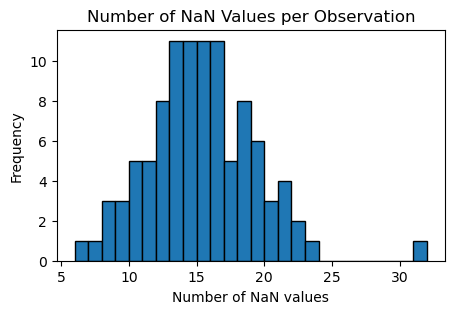

In [104]:
# Calculate the number of NaN values in each row
na_counts = df.isna().sum(axis=1)

# Plot the number of NaNs for each row
plt.figure(figsize=(5, 3))
plt.hist(na_counts, bins=range(int(na_counts.min()), int(na_counts.max()) + 1), edgecolor='black')
plt.title('Number of NaN Values per Observation')
plt.xlabel('Number of NaN values')
plt.ylabel('Frequency')
plt.show()

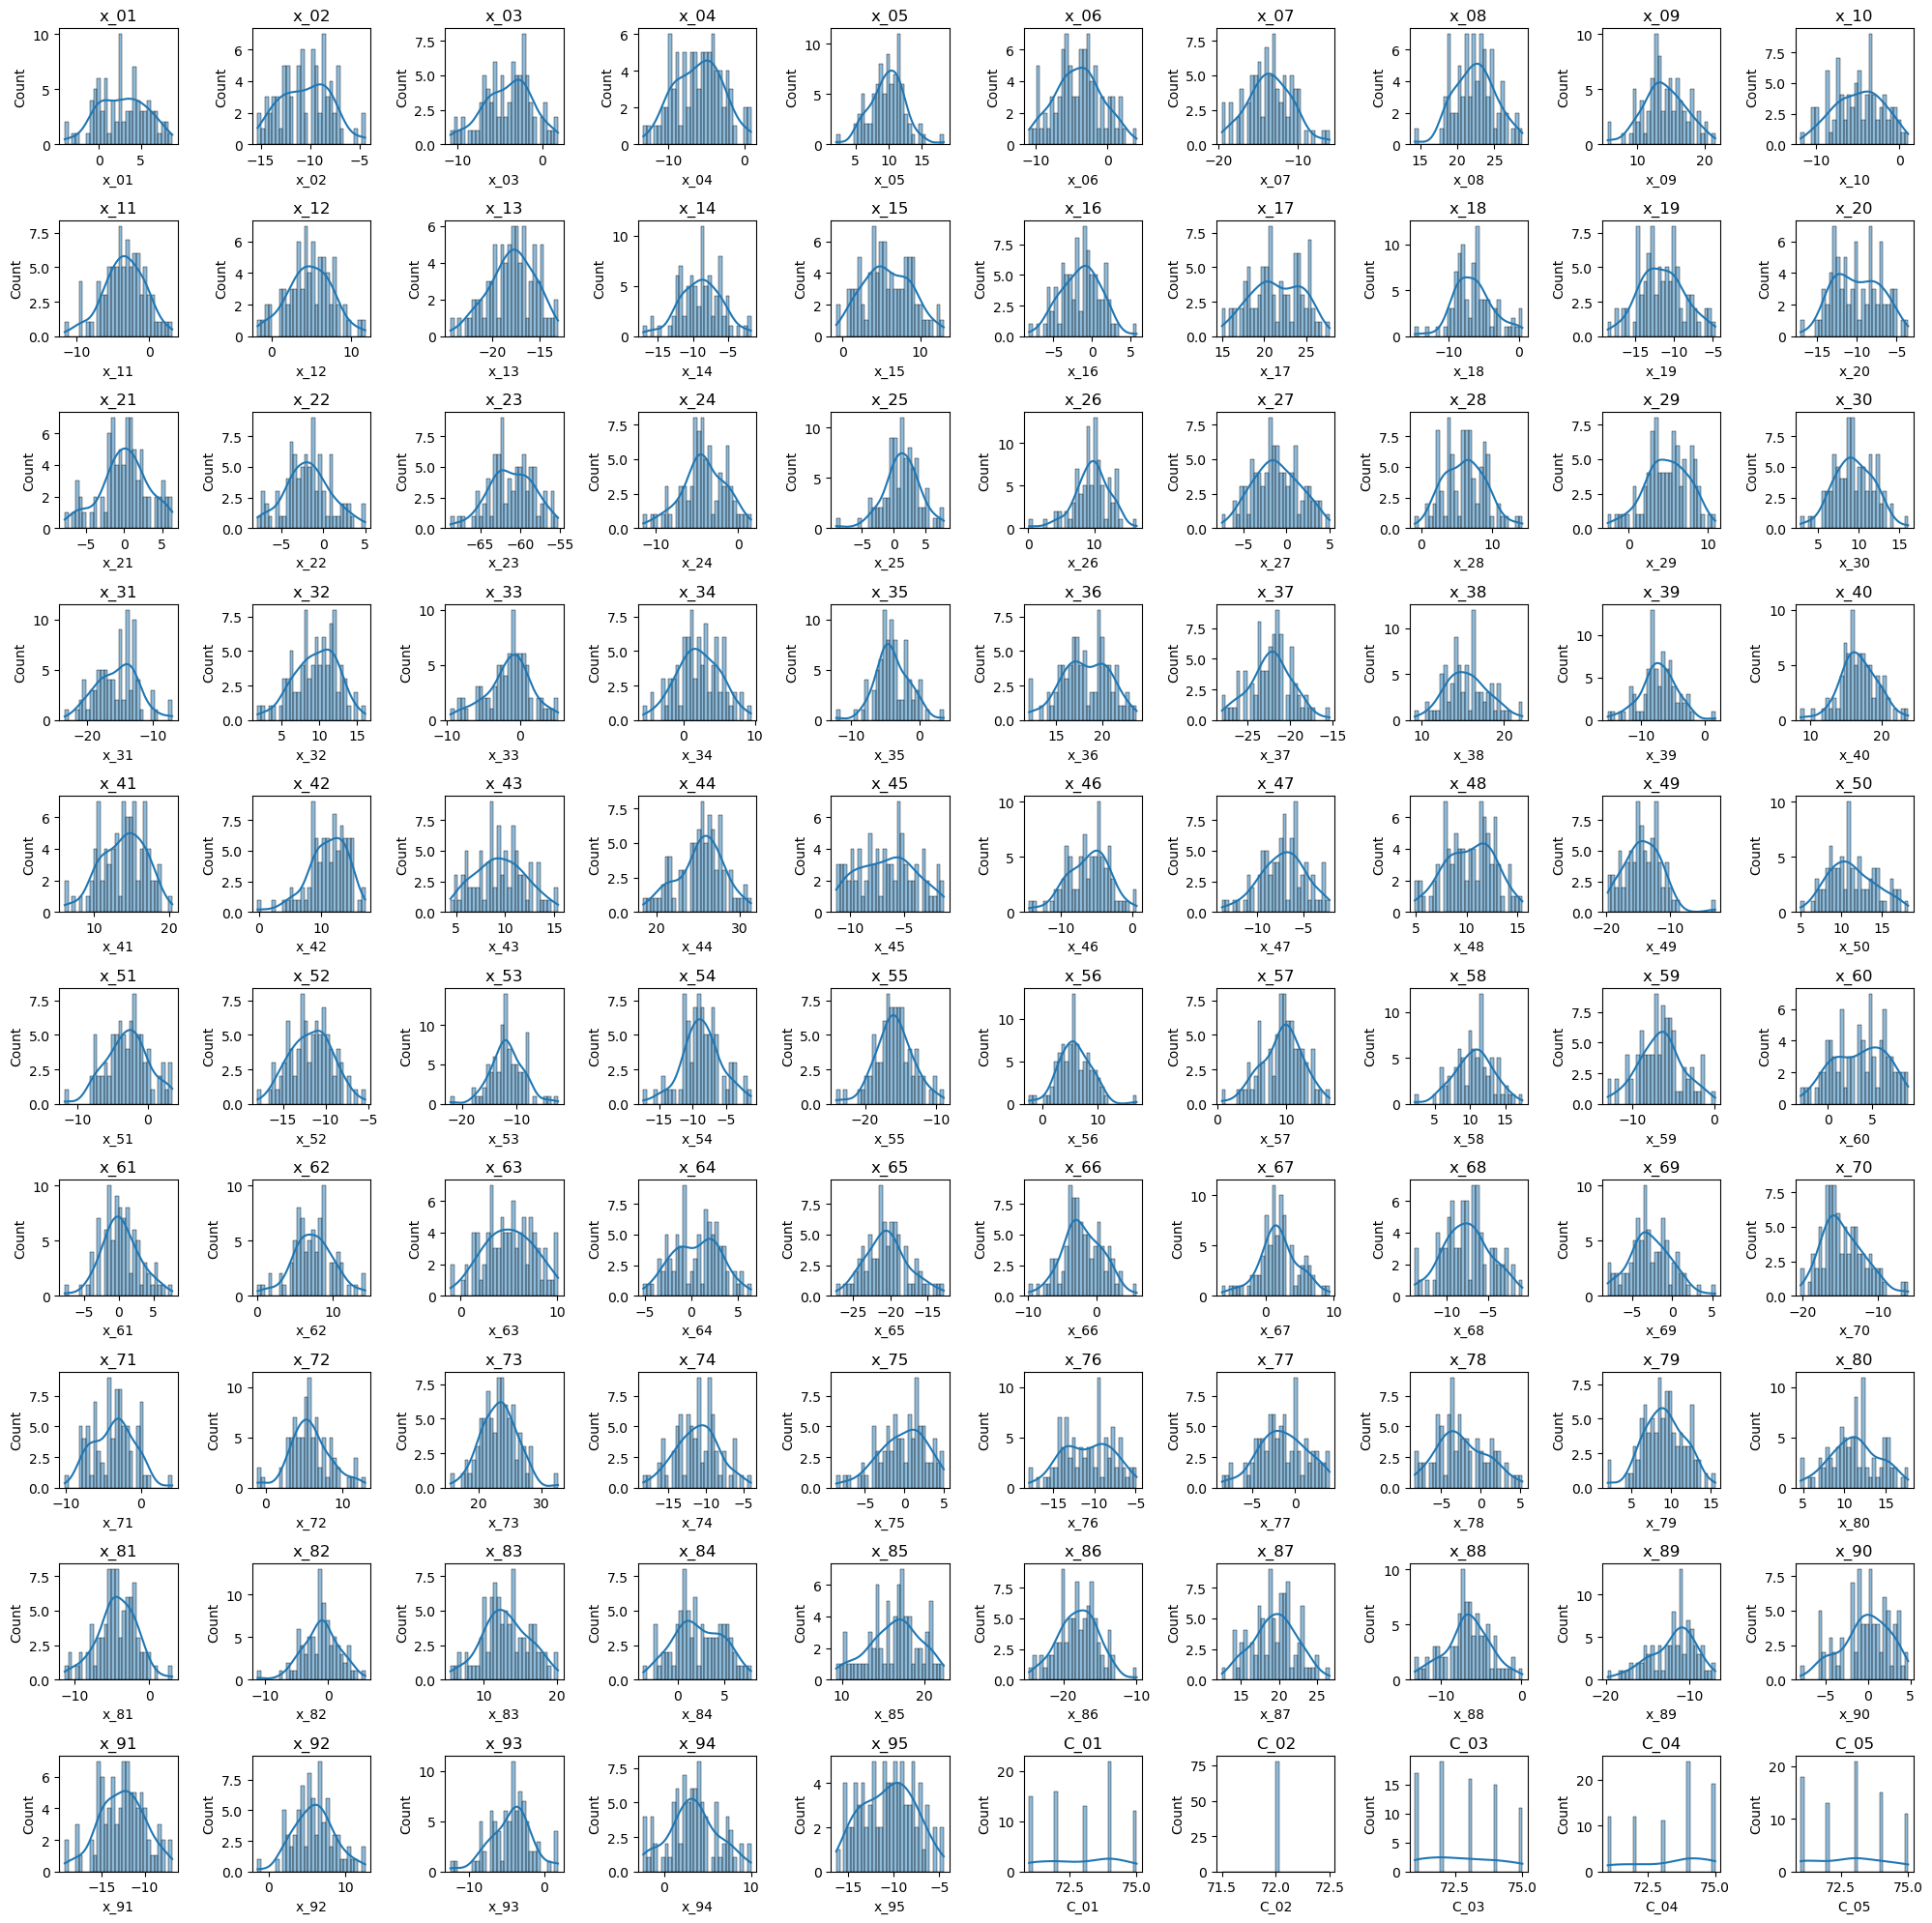

In [105]:
# Select only numerical columns
num_cols = X.select_dtypes(include=['number']).columns

# Define the number of subplots
n_cols = 10  # Number of columns per row
n_rows = 10 # Calculate rows dynamically

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))  # Adjust figure size
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, col in enumerate(num_cols):
    sns.histplot(X[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(col)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [107]:
### SEperating continuous predictors and categorical predictors
df_cont = df[[col for col in df.columns if col.startswith("x")]]
df_cat = df[[col for col in df.columns if col.startswith("C")]]

Correlation analysis because why not

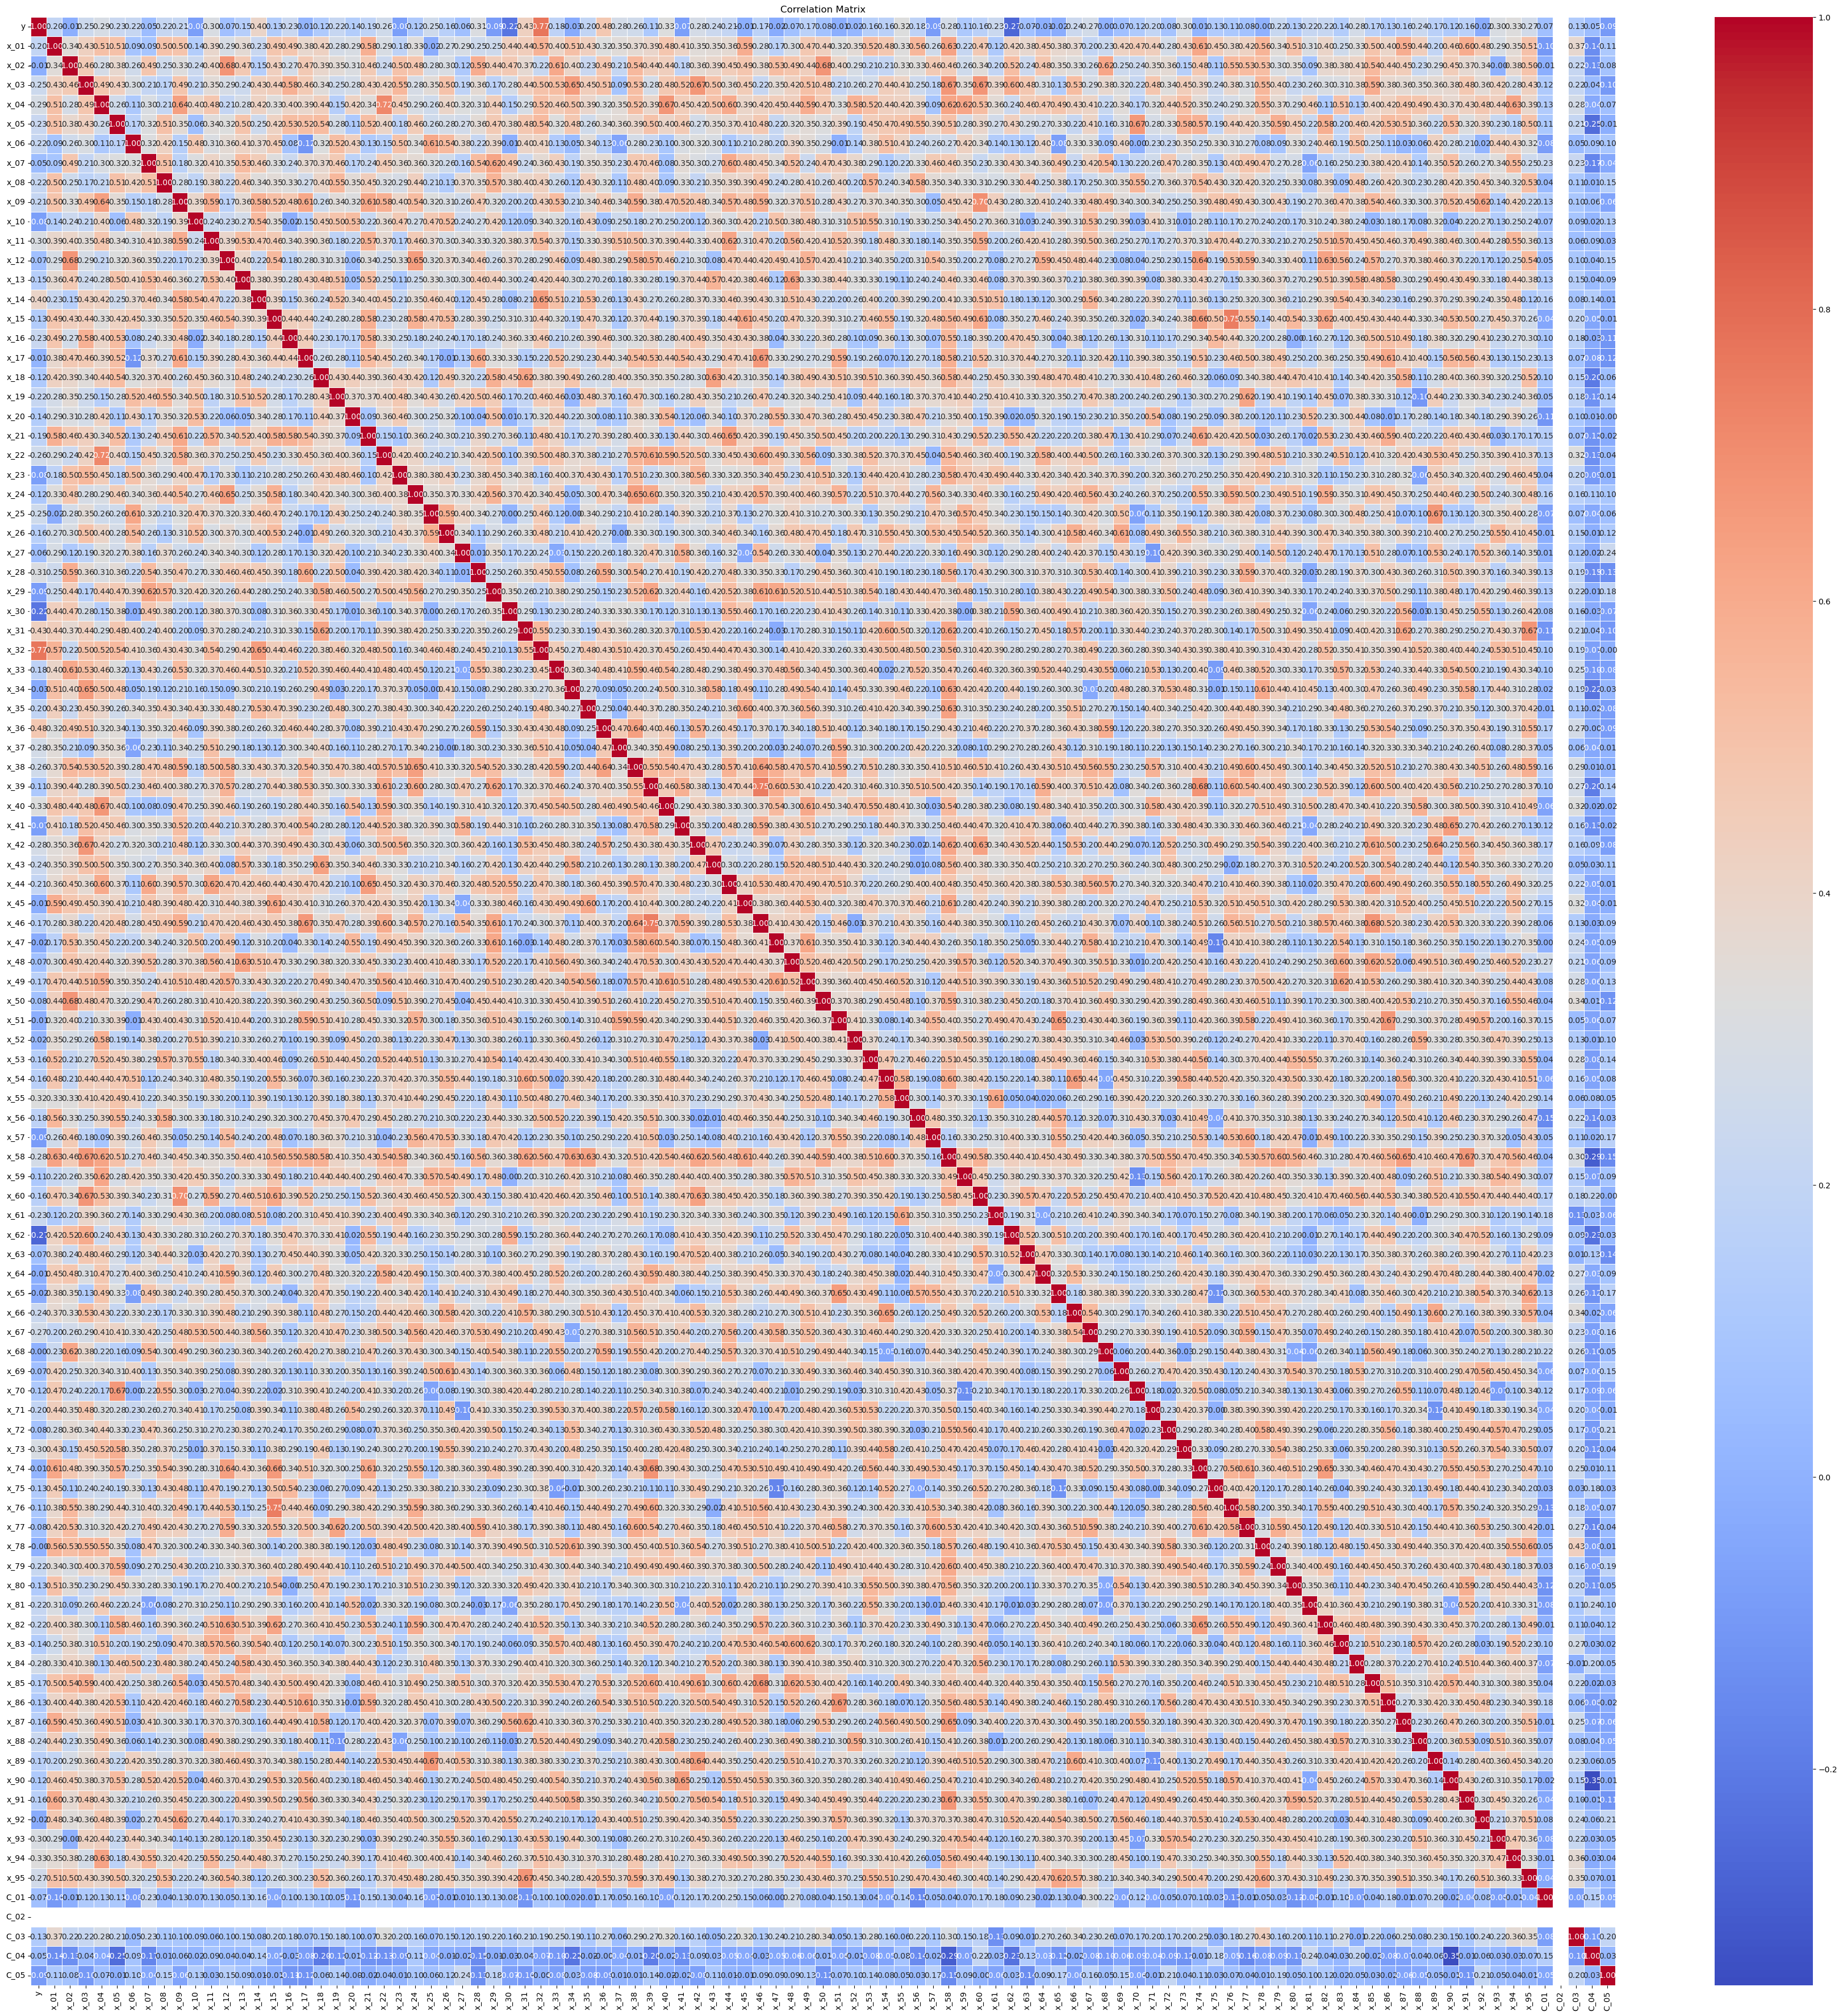

In [173]:
# Compute correlation
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(45, 45))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [109]:
# Get the correlation of each column with 'y'
correlation_with_y = corr_matrix['y']

# Sort the correlations in descending order
sorted_correlation = correlation_with_y.sort_values(ascending=False)

# Print columns most correlated with 'y'
print(sorted_correlation.drop("y").head(10))

x_32    0.770303
x_36    0.478040
x_31    0.426011
x_14    0.404301
x_94    0.330637
x_40    0.325519
x_55    0.323713
x_28    0.313412
x_93    0.303670
x_11    0.302154
Name: y, dtype: float64


### Dealing with continuous predictors (df.cont)

Checking how skewed the data is (tolerated if -1 < data < 1)

In [111]:
skewness = df_cont.skew()

# Filter columns with skewness > 1 or < -1 (indicating highly skewed data)
highly_skewed = skewness[abs(skewness) > 1]

print(highly_skewed)

Series([], dtype: float64)


In [113]:
### Checking for outlyers (IQR (Interquartile Range))
cols_with_outlyers = []

for col in df_cont.columns:

    Q1 = df_cont[col].quantile(0.25)
    Q3 = df_cont[col].quantile(0.75)
    
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_cont[(df_cont[col] < lower_bound) | (df_cont[col] > upper_bound)]

    if not outliers.empty:
        cols_with_outlyers.append(col) 
        
print(f"Continuous predictors having outlyers are {cols_with_outlyers}")

Continuous predictors having outlyers are ['x_05', 'x_08', 'x_09', 'x_11', 'x_14', 'x_16', 'x_18', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_29', 'x_32', 'x_33', 'x_35', 'x_37', 'x_39', 'x_40', 'x_42', 'x_44', 'x_49', 'x_51', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_61', 'x_62', 'x_65', 'x_66', 'x_67', 'x_69', 'x_70', 'x_71', 'x_72', 'x_73', 'x_75', 'x_81', 'x_82', 'x_86', 'x_88', 'x_89', 'x_90', 'x_92', 'x_93', 'x_94']


Winsorization of outlyers coming form continuous predictors, checking if predictors no longer have outlyers

In [114]:
# Define percentiles for capping
lower_percentile = 5
upper_percentile = 95
cols_with_outlyers = []

# Cap the outliers in the specified columns
for col in df_cont.columns:
    lower_cap = df_cont[col].quantile(lower_percentile / 100)
    upper_cap = df_cont[col].quantile(upper_percentile / 100)
    
    df_cont.loc[:, col] = df_cont[col].clip(lower=lower_cap, upper=upper_cap)

    Q1 = df_cont[col].quantile(0.25)
    Q3 = df_cont[col].quantile(0.75)
    
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_cont[(df_cont[col] < lower_bound) | (df_cont[col] > upper_bound)]

    if not outliers.empty:
        cols_with_outlyers.append(col)

print(f"Continuous predictors having outlyers are {cols_with_outlyers}")

Continuous predictors having outlyers are []


**Result:** Predictors no longer have outlyers!

#### Filling NaN values with mean of the predictors (mean of the columns)

In [115]:
#Filling NaN values
df_cont = df_cont.fillna(df_cont.mean())

# If NaN were filled correctly the df.shape after droping rows with NaN should be the same
df_cont.dropna().shape

(100, 95)

#### Instead of filling NaN values with mean of the predictor, use KNN Imputer (Scikit-Learn).

This imputer utilizes the k-Nearest Neighbors method to replace the missing values in the datasets with the mean value from the parameter ‘n_neighbors’ nearest neighbors found in the training set. By default, it uses a Euclidean distance metric to impute the missing values.

Another critical point here is that the KNN Imptuer is a distance-based imputation method and it requires us to **normalize** our data. Otherwise, the different scales of our data will lead the KNN Imputer to generate biased replacements for the missing values. For simplicity, we will use Scikit-Learn’s MinMaxScaler which will scale our variables to have values between 0 and 1.

We are setting the parameter ‘n_neighbors’ as 5. So, the missing values will be replaced by the mean value of 5 nearest neighbors measured by Euclidean distance.

```python
scaler = MinMaxScaler()
df_ = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

imputer = KNNImputer(n_neighbors=5)
df_ = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
df.head(10)
```

In [162]:
df_filled = df.copy()

# Separate categorical and continuous columns
continuous_columns = [x for x in df.columns if x.startswith("x_")]
categorical_columns = [x for x in df.columns if x.startswith("C_")]

### Continuous
# Normalize continuous columns
scaler = MinMaxScaler()
df_filled[continuous_columns] = scaler.fit_transform(df_filled[continuous_columns])

# Impute missing values for continuous columns using KNNImputer (with n_neighbors=5)
knn_imputer_cont = KNNImputer(n_neighbors=5)
df_imputed_cont = pd.DataFrame(knn_imputer_cont.fit_transform(df_filled[continuous_columns]), columns=continuous_columns)

### Categorical

# Normalize categorical columns (if you decide to normalize them)
#df_filled[categorical_columns] = MinMaxScaler().fit_transform(df_filled[categorical_columns])

# Impute missing values for categorical columns using KNNImputer (with n_neighbors=1)
knn_imputer_cat = KNNImputer(n_neighbors=1)
df_imputed_cat = pd.DataFrame(knn_imputer_cat.fit_transform(df_filled[categorical_columns]), columns=categorical_columns)

# Combine the imputed continuous and categorical data back into a single DataFrame
df_imputed = pd.concat([df_imputed_cont, df_imputed_cat], axis=1)

# Round categorical columns to the nearest allowed category (71, 72, 73, 74, 75)
# First, we can map the imputed continuous values back to one of the allowed categories
allowed_categories = [71, 72, 73, 74, 75]
for col in categorical_columns:
    # Round the imputed values to the nearest allowed category
    df_imputed[col] = df_imputed[col].round().astype(int)
    df_imputed[col] = df_imputed[col].apply(lambda x: min(allowed_categories, key=lambda y: abs(y - x)))

# Reverse normalization for continuous columns (inverse_transform)
df_imputed[continuous_columns] = scaler.inverse_transform(df_imputed[continuous_columns])

# Display the final imputed DataFrame
df_imputed.head(10)

x_01       x_02      x_03       x_04       x_05      x_06       x_07  \
0  6.359019 -13.367120 -2.483750  -6.641891  11.733539 -4.536957 -17.085361   
1  3.873664  -8.470389 -3.055012  -3.442690  11.420983  1.822330 -13.694100   
2  5.275824 -12.070531 -1.366168  -4.819100  10.721527 -5.125992 -17.476865   
3  4.430110  -4.467975 -0.730736 -10.047104  11.498539 -2.870260 -14.033012   
4  3.116458  -8.518713 -6.796050  -5.557716   7.646285 -3.118309 -13.102567   
5  2.478883 -10.347278 -3.574333  -4.320143  10.536010 -3.326662 -13.197508   
6  0.497803  -9.389992 -7.230404  -8.852222  12.308068 -5.288380  -9.998207   
7  7.627311  -7.146660  0.244472   0.182987  10.978907 -0.395215 -14.423119   
8  4.981034  -8.719028 -5.484942  -5.919929   9.916674 -4.726807 -10.606375   
9  0.519655 -14.477831 -2.121282  -6.043646  12.080162 -6.393721 -11.599432   

        x_08       x_09       x_10  ...       x_91       x_92      x_93  \
0  22.194764  16.827888 -10.367142  ... -10.200888   3.980048 -4.433274   
1  22.738654  20.307503  -2.859097  ...  -9.740207   8.931802 -2.629314   
2  22.769771  15.963889  -3.257940  ... -14.501970  10.054005 -4.332089   
3  18.225190  10.409488  -5.616061  ... -11.086963   2.019726 -8.531959   
4  22.801217  16.680208  -3.357765  ...  -9.117422   6.627601 -2.805531   
5  23.424267  12.551075  -4.640140  ... -11.571283   7.487204 -5.098366   
6  23.229430  13.491712  -3.364379  ... -15.720359   5.225614 -6.235942   
7  24.741921  16.251380  -3.783016  ... -10.710254   7.884195 -2.402023   
8  24.903043  12.151393  -3.406515  ... -11.139651   7.096430 -2.865486   
9  19.113607  11.984299  -6.710642  ... -14.195198   2.409425 -3.523658   

       x_94       x_95  C_01  C_02  C_03  C_04  C_05  
0 -1.473723  -9.839529    74    72    72    73    73  
1  4.816987 -12.240248    74    72    72    73    73  
2  2.681499 -11.107921    73    72    75    74    74  
3  3.520833 -11.265643    71    72    73    71    72  
4  5.914351 -11.240573    72    72    72    74    75  
5  3.175914  -9.610356    71    72    74    71    75  
6  4.124001 -16.268568    74    72    75    71    75  
7  8.286169  -4.631043    74    72    73    75    73  
8  7.464922  -8.441735    73    72    73    73    73  
9  2.821658 -14.591262    75    72    72    74    71  

[10 rows x 100 columns]

In [169]:
df_filled = df.copy()

# Separate categorical and continuous columns
categorical_columns = [col for col in df_filled.columns if col.startswith('C_')]
continuous_columns = [col for col in df_filled.columns if col.startswith('x_')]

# Normalize continuous columns (important for KNN)
scaler = MinMaxScaler()
df_continuous_scaled = scaler.fit_transform(df_filled[continuous_columns])

# Impute missing values for continuous columns using KNNImputer (with n_neighbors=5)
knn_imputer_cont = KNNImputer(n_neighbors=5)
df_imputed_cont = pd.DataFrame(knn_imputer_cont.fit_transform(df_continuous_scaled), columns=continuous_columns)

# Combine the imputed continuous columns with the original categorical columns (without changes yet)
df_combined = pd.concat([pd.DataFrame(df_continuous_scaled, columns=continuous_columns), df_filled[categorical_columns]], axis=1)

# Apply KNN Imputer to fill missing values in categorical columns, using the continuous data to guide the imputation
knn_imputer_cat = KNNImputer(n_neighbors=1)
df_imputed_combined = pd.DataFrame(knn_imputer_cat.fit_transform(df_combined), columns=df_combined.columns)

# After imputation, make sure categorical columns are rounded to the nearest valid category
# (e.g., 71, 72, 73, 74, 75) and convert back to integers
for col in categorical_columns:
    df_imputed_combined[col] = df_imputed_combined[col].round().astype(int)
    # Clip values to ensure they are within the valid categories (71, 72, 73, 74, 75)
    df_imputed_combined[col] = df_imputed_combined[col].clip(lower=71, upper=75)

df_imputed_combined[continuous_columns] = scaler.inverse_transform(df_imputed_cont[continuous_columns])

# Resulting DataFrame with imputed categorical columns and continuous columns
df_imputed_combined.head(20)

x_01       x_02      x_03       x_04       x_05      x_06       x_07  \
0   6.359019 -13.367120 -2.483750  -6.641891  11.733539 -4.536957 -17.085361   
1   3.873664  -8.470389 -3.055012  -3.442690  11.420983  1.822330 -13.694100   
2   5.275824 -12.070531 -1.366168  -4.819100  10.721527 -5.125992 -17.476865   
3   4.430110  -4.467975 -0.730736 -10.047104  11.498539 -2.870260 -14.033012   
4   3.116458  -8.518713 -6.796050  -5.557716   7.646285 -3.118309 -13.102567   
5   2.478883 -10.347278 -3.574333  -4.320143  10.536010 -3.326662 -13.197508   
6   0.497803  -9.389992 -7.230404  -8.852222  12.308068 -5.288380  -9.998207   
7   7.627311  -7.146660  0.244472   0.182987  10.978907 -0.395215 -14.423119   
8   4.981034  -8.719028 -5.484942  -5.919929   9.916674 -4.726807 -10.606375   
9   0.519655 -14.477831 -2.121282  -6.043646  12.080162 -6.393721 -11.599432   
10  3.885056  -9.967048 -5.107643  -6.555450  12.120686 -3.253387 -11.983608   
11 -1.155884 -12.757854 -3.631874 -11.587638   5.903194 -5.895661 -19.338886   
12 -0.106158 -10.860288 -6.234470  -7.639188   6.583835 -9.539841 -12.769784   
13  4.719108  -9.774988 -5.611740  -7.769836  11.775940 -3.973173 -11.788280   
14  7.253432  -7.151056 -1.749698   0.149149  10.299341 -4.698378  -8.779604   
15  7.893687  -7.252485  1.840223  -1.836295  15.114998 -2.865133 -11.181299   
16  5.563300 -11.755998 -6.718951  -7.397353   9.380848 -7.539477 -12.388125   
17  4.476289  -9.170604 -1.860214  -3.360489   9.374875 -1.823342 -14.586488   
18  2.654725  -9.174334 -4.111664  -5.153257  10.299110 -3.596055 -12.990732   
19  3.712622  -8.380650 -2.822022  -5.149488  10.152807 -6.678389 -12.669591   

         x_08       x_09       x_10  ...       x_91       x_92      x_93  \
0   22.194764  16.827888 -10.367142  ... -10.200888   3.980048 -4.433274   
1   22.738654  20.307503  -2.859097  ...  -9.740207   8.931802 -2.629314   
2   22.769771  15.963889  -3.257940  ... -14.501970  10.054005 -4.332089   
3   18.225190  10.409488  -5.616061  ... -11.086963   2.019726 -8.531959   
4   22.801217  16.680208  -3.357765  ...  -9.117422   6.627601 -2.805531   
5   23.424267  12.551075  -4.640140  ... -11.571283   7.487204 -5.098366   
6   23.229430  13.491712  -3.364379  ... -15.720359   5.225614 -6.235942   
7   24.741921  16.251380  -3.783016  ... -10.710254   7.884195 -2.402023   
8   24.903043  12.151393  -3.406515  ... -11.139651   7.096430 -2.865486   
9   19.113607  11.984299  -6.710642  ... -14.195198   2.409425 -3.523658   
10  25.152454   9.986395  -5.221033  ... -12.215629   1.208600 -0.693872   
11  18.653807   9.774830  -8.336451  ... -13.149112  -1.428501 -8.260216   
12  18.899273  13.132029  -6.705646  ... -15.139369   5.587747 -8.527419   
13  20.330828  12.567657  -5.534820  ... -11.764029   1.908606 -5.295948   
14  25.646631  18.308828  -0.380087  ...  -9.821806  12.483437 -4.251215   
15  24.222203  16.205334  -2.319367  ...  -8.094123  12.575124  1.774481   
16  24.650480  11.730425  -9.783073  ... -12.143626   9.099460 -3.261983   
17  22.367173  15.565790  -0.773886  ... -10.333984   4.624841 -3.186298   
18  22.046083  19.136701   0.248301  ...  -8.766429  10.712874 -7.208655   
19  24.479586  13.256727  -9.895786  ...  -9.882772   6.665978 -2.920971   

        x_94       x_95  C_01  C_02  C_03  C_04  C_05  
0  -1.473723  -9.839529    74    72    72    73    73  
1   4.816987 -12.240248    74    72    72    73    73  
2   2.681499 -11.107921    73    72    75    74    74  
3   3.520833 -11.265643    71    72    73    71    72  
4   5.914351 -11.240573    72    72    72    74    75  
5   3.175914  -9.610356    71    72    74    71    75  
6   4.124001 -16.268568    74    72    75    71    75  
7   8.286169  -4.631043    74    72    73    75    73  
8   7.464922  -8.441735    71    72    72    72    72  
9   2.821658 -14.591262    75    72    72    74    71  
10  2.349841 -10.712904    75    72    71    74    75  
11 -2.375809 -14.294014    75    72    72    74    71  
12

In [156]:
df.head(20)

y      x_01       x_02      x_03       x_04       x_05      x_06  \
0   375.823073  6.359019 -13.367120 -2.483750  -6.641891  11.733539       NaN   
1   266.811730  3.873664  -8.470389 -3.055012        NaN  11.420983  1.822330   
2   267.271759  5.275824 -12.070531 -1.366168  -4.819100  10.721527 -5.125992   
3   219.951294  4.430110  -4.467975 -0.730736 -10.047104  11.498539 -2.870260   
4   289.697954  3.116458  -8.518713 -6.796050        NaN   7.646285 -3.118309   
5   265.753204  2.478883 -10.347278 -3.574333  -4.320143        NaN -3.326662   
6   133.594186  0.497803  -9.389992 -7.230404  -8.852222  12.308068 -5.288380   
7   252.251096  7.627311  -7.146660  0.244472   0.182987        NaN -0.395215   
8   163.402815  4.981034  -8.719028 -5.484942  -5.919929   9.916674 -4.726807   
9   282.511836  0.519655 -14.477831 -2.121282        NaN  12.080162 -6.393721   
10  260.274169  3.885056        NaN       NaN  -6.555450  12.120686 -3.253387   
11  230.800380 -1.155884 -12.757854 -3.631874 -11.587638   5.903194       NaN   
12  106.478552       NaN -10.860288 -6.234470  -7.639188   6.583835 -9.539841   
13  221.756130  4.719108  -9.774988 -5.611740  -7.769836  11.775940 -3.973173   
14  192.121552  7.253432  -7.151056       NaN   0.149149        NaN -4.698378   
15  172.204557  7.893687  -7.252485  1.840223  -1.836295  15.114998 -2.865133   
16  196.298574  5.563300 -11.755998 -6.718951  -7.397353   9.380848 -7.539477   
17  174.769693  4.476289        NaN -1.860214  -3.360489   9.374875 -1.823342   
18  231.414661  2.654725        NaN -4.111664        NaN  10.299110 -3.596055   
19  139.498771       NaN  -8.380650 -2.822022        NaN        NaN -6.678389   

         x_07       x_08       x_09  ...       x_91       x_92      x_93  \
0  -17.085361  22.194764  16.827888  ... -10.200888   3.980048 -4.433274   
1  -13.694100  22.738654  20.307503  ...  -9.740207        NaN -2.629314   
2  -17.476865        NaN  15.963889  ... -14.501970  10.054005       NaN   
3  -14.033012  18.225190  10.409488  ... -11.086963   2.019726 -8.531959   
4  -13.102567  22.801217  16.680208  ...  -9.117422   6.627601 -2.805531   
5  -13.197508  23.424267  12.551075  ... -11.571283   7.487204 -5.098366   
6   -9.998207  23.229430  13.491712  ... -15.720359        NaN -6.235942   
7  -14.423119        NaN        NaN  ... -10.710254   7.884195 -2.402023   
8  -10.606375  24.903043  12.151393  ... -11.139651   7.096430 -2.865486   
9  -11.599432        NaN  11.984299  ... -14.195198   2.409425 -3.523658   
10 -11.983608  25.152454   9.986395  ... -12.215629   1.208600 -0.693872   
11 -19.338886  18.653807   9.774830  ... -13.149112  -1.428501 -8.260216   
12        NaN  18.899273  13.132029  ... -15.139369   5.587747 -8.527419   
13 -11.788280  20.330828  12.567657  ... -11.764029   1.908606 -5.295948   
14  -8.779604  25.646631  18.308828  ...  -9.821806  12.483437 -4.251215   
15 -11.181299        NaN        NaN  ...  -8.094123  12.575124  1.774481   
16 -12.388125  24.650480        NaN  ... -12.143626   9.099460 -3.261983   
17 -14.586488  22.367173  15.565790  ... -10.333984   4.624841 -3.186298   
18        NaN  22.046083  19.136701  ...  -8.766429  10.712874 -7.208655   
19 -12.669591        NaN  13.256727  ...  -9.882772   6.665978 -2.920971   

        x_94       x_95  C_01  C_02  C_03  C_04  C_05  
0  -1.473723        NaN  74.0  72.0  72.0  73.0  73.0  
1   4.816987 -12.240248  74.0  72.0  72.0  73.0  73.0  
2        NaN -11.107921  73.0  72.0  75.0  74.0  74.0  
3   3.520833        NaN  71.0  72.0  73.0  71.0  72.0  
4   5.914351 -11.240573  72.0  72.0  72.0  74.0  75.0  
5   3.175914  -9.610356  71.0  72.0  74.0  71.0  75.0  
6   4.124001 -16.268568  74.0  72.0  75.0  71.0  75.0  
7        NaN  -4.631043  74.0  72.0  73.0  75.0  73.0  
8   7.464922  -8.441735   NaN   NaN   NaN   NaN   NaN  
9   2.821658 -14.591262  75.0  72.0  72.0  74.0  71.0  
10  2.349841        NaN   NaN   NaN   NaN   NaN   NaN  
11 -2.375809 -14.294014  75.0  72.0  72.0 

**Result:** no more continuous predictors with NaN values!

### Dealing with categorical predictors (df_cat)

In [116]:
for col in df_cat.columns:
    print(f"Unique values in {col}: {pd.unique(df_cat[col])}")

Unique values in C_01: [74. 73. 71. 72. nan 75.]
Unique values in C_02: [72. nan]
Unique values in C_03: [72. 75. 73. 74. nan 71.]
Unique values in C_04: [73. 74. 71. 75. nan 72.]
Unique values in C_05: [73. 74. 72. 75. nan 71.]


Filling NaN vlaues in df_cat with category "NaN" so that later this information can be used for 1-hot-encoding.

In [117]:
# NaN values are changes to new category "NaN" for later 1-hot-encoding
df_cat = df_cat.fillna('NaN')

# Printing unique values per predictor
for col in df_cat.columns:
    print(f"Unique values in {col}: {pd.unique(df_cat[col])}")

Unique values in C_01: [74.0 73.0 71.0 72.0 'NaN' 75.0]
Unique values in C_02: [72.0 'NaN']
Unique values in C_03: [72.0 75.0 73.0 74.0 'NaN' 71.0]
Unique values in C_04: [73.0 74.0 71.0 75.0 'NaN' 72.0]
Unique values in C_05: [73.0 74.0 72.0 75.0 'NaN' 71.0]


In [122]:
df_cat_encoded = pd.get_dummies(df_cat, columns=df_cat.columns)
df_cat_encoded = df_cat_encoded.astype(int)
df_cat_encoded.head(5)

C_01_71.0  C_01_72.0  C_01_73.0  C_01_74.0  C_01_75.0  C_01_NaN  C_02_72.0  \
0          0          0          0          1          0         0          1   
1          0          0          0          1          0         0          1   
2          0          0          1          0          0         0          1   
3          1          0          0          0          0         0          1   
4          0          1          0          0          0         0          1   

   C_02_NaN  C_03_71.0  C_03_72.0  ...  C_04_73.0  C_04_74.0  C_04_75.0  \
0         0          0          1  ...          1          0          0   
1         0          0          1  ...          1          0          0   
2         0          0          0  ...          0          1          0   
3         0          0          0  ...          0          0          0   
4         0          0          1  ...          0          1          0   

   C_04_NaN  C_05_71.0  C_05_72.0  C_05_73.0  C_05_74.0  C_05_75.0  C_05_NaN  
0         0          0          0          1          0          0         0  
1         0          0          0          1          0          0         0  
2         0          0          0          0          1          0         0  
3         0          0          1          0          0          0         0  
4         0          0          0          0          0          1         0  

[5 rows x 26 columns]

### Merging df_cont after winsorization and NaN values filling with df_cat_encoded (df_cat after 1-hot encoding)

In [124]:
df_final = pd.concat([df_cont, df_cat_encoded], axis=1)
df_final.head()

x_01       x_02      x_03       x_04       x_05      x_06       x_07  \
0  6.359019 -13.367120 -2.483750  -6.641891  11.733539 -4.073651 -17.085361   
1  3.873664  -8.470389 -3.055012  -6.052529  11.420983  1.557519 -13.694100   
2  5.275824 -12.070531 -1.366168  -4.819100  10.721527 -5.125992 -17.476865   
3  4.430110  -7.104004 -0.730736 -10.047104  11.498539 -2.870260 -14.033012   
4  3.116458  -8.518713 -6.796050  -6.052529   7.646285 -3.118309 -13.102567   

        x_08       x_09       x_10  ...  C_04_73.0  C_04_74.0  C_04_75.0  \
0  22.194764  16.827888 -10.005761  ...          1          0          0   
1  22.738654  19.249430  -2.859097  ...          1          0          0   
2  22.439957  15.963889  -3.257940  ...          0          1          0   
3  18.619349  10.409488  -5.616061  ...          0          0          0   
4  22.801217  16.680208  -3.357765  ...          0          1          0   

   C_04_NaN  C_05_71.0  C_05_72.0  C_05_73.0  C_05_74.0  C_05_75.0  C_05_NaN  
0         0          0          0          1          0          0         0  
1         0          0          0          1          0          0         0  
2         0          0          0          0          1          0         0  
3         0          0          1          0          0          0         0  
4         0          0          0          0          0          1         0  

[5 rows x 121 columns]

In [125]:
df_cat_encoded = pd.concat([df[[col for col in df.columns if col.startswith("x")]], df_cat_encoded], axis=1)
df_cat_encoded.head(5)

x_01       x_02      x_03       x_04       x_05      x_06       x_07  \
0  6.359019 -13.367120 -2.483750  -6.641891  11.733539       NaN -17.085361   
1  3.873664  -8.470389 -3.055012        NaN  11.420983  1.822330 -13.694100   
2  5.275824 -12.070531 -1.366168  -4.819100  10.721527 -5.125992 -17.476865   
3  4.430110  -4.467975 -0.730736 -10.047104  11.498539 -2.870260 -14.033012   
4  3.116458  -8.518713 -6.796050        NaN   7.646285 -3.118309 -13.102567   

        x_08       x_09       x_10  ...  C_04_73.0  C_04_74.0  C_04_75.0  \
0  22.194764  16.827888 -10.367142  ...          1          0          0   
1  22.738654  20.307503  -2.859097  ...          1          0          0   
2        NaN  15.963889  -3.257940  ...          0          1          0   
3  18.225190  10.409488  -5.616061  ...          0          0          0   
4  22.801217  16.680208  -3.357765  ...          0          1          0   

   C_04_NaN  C_05_71.0  C_05_72.0  C_05_73.0  C_05_74.0  C_05_75.0  C_05_NaN  
0         0          0          0          1          0          0         0  
1         0          0          0          1          0          0         0  
2         0          0          0          0          1          0         0  
3         0          0          1          0          0          0         0  
4         0          0          0          0          0          1         0  

[5 rows x 121 columns]

We cannot drop missing values contianing rows, as we would drop all the data.

We need to fill missing values. Two options:
1. Using mean/median/mode
2. KNN imputation (based on the certain number of neighbours, might need to perform CV)

Use KNN to fill the misisng vlaues (KNN imputation)

https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e

```python
from sklearn.impute import KNNImputer

Impute using k-nearest neighbors for numerical columns
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
```